In [1]:
import YXJ
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
# ----------------------------------- 数据提取 -------------------------------- 
file_names1 = ['A1', 'A2', 'A1','A1','A3', 'A1','A1','A4', 'A1']
file_names2 = ['R1', 'R2', 'R1','R1','R3', 'R1','R1','R4','R1']
file_names3 = ['G1', 'G2', 'G1','G1','G3', 'G1','G1','G4','G1']
data_frames = []

for name in file_names1:
    df = pd.read_excel(f"data/{name}.xlsx")
    data_frames.append(df)

df1 = pd.concat(data_frames, axis=0)

data_frames = []

for name in file_names2:
    df = pd.read_excel(f"data/{name}.xlsx")
    data_frames.append(df)

df2 = pd.concat(data_frames, axis=0)

data_frames = []

for name in file_names3:
    df = pd.read_excel(f"data/{name}.xlsx")
    data_frames.append(df)

df3 = pd.concat(data_frames, axis=0)

In [2]:
df1.columns = ["Timestamp", "Acceleration-X", "Acceleration-Y", "Acceleration-Z"]  
df2.columns = ["Timestamp", "AngularVelocity-X", "AngularVelocity-Y", "AngularVelocity-Z"]
df3.columns = ["Timestamp","latitude", "longitude", "altitude","speed","cource","hacc"]

# 从表格中提取collum作为numpy数组
timestamp = df1["Timestamp"].to_numpy()
acceleration_x = df1["Acceleration-X"].to_numpy()
acceleration_y = df1["Acceleration-Y"].to_numpy()
acceleration_z = df1["Acceleration-Z"].to_numpy()

latitude = df3["latitude"].to_numpy()
longitude = df3["longitude"].to_numpy()
altitude = df3["altitude"].to_numpy()

IMUdataLength =len(acceleration_x)
GPSdataLength =len(latitude)

#拉长数据，线性插值
upsampled_la= YXJ.upsampling(IMUdataLength, latitude)
upsampled_al =YXJ.upsampling(IMUdataLength, altitude)
upsampled_lo =YXJ.upsampling(IMUdataLength, longitude)

### --------------------------------------- 归一化---------------------------------------------
lo, al, la, x, y, z = [YXJ.normalization(data) for data in [upsampled_lo, upsampled_al, upsampled_la, acceleration_x, acceleration_y, acceleration_z]]

In [3]:
# ----------------------------------- 打标签 --------------------------------
'''#生成一个同长度的numpy，随机0，1
isSmoke = np.random.randint(2, size=IMUdataLength)
print(isSmoke)
'''
# 将时间戳转换为datetime类型
timestamp = df1["Timestamp"].to_numpy()
datetime_array = np.array([pd.to_datetime(ts) for ts in timestamp])

# 转换为pandas的DateTimeIndex对象
datetime_index = pd.DatetimeIndex(datetime_array)

# 标记日期为9号的数据为1，其余为0
isSmoke = np.where(datetime_index.day == 9, 1, 0)

In [4]:
### ------------------------------------合并数据并转成tensor---------------------------------------------
X_data = torch.tensor([x, y, z, lo, al, la]).T
y_data = torch.tensor(isSmoke)

C:\Users\65133\AppData\Local\Temp\ipykernel_39712\2040150335.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  X_data = torch.tensor([x, y, z, lo, al, la]).T


In [5]:
## --------------------------------------- 划分样本---------------------------------------------
width =100           # 单个样本的长度
X_data = YXJ.Split2Samples(X_data, width)                # 等分分割全部历史数据生成多个样本
X_data = torch.transpose(X_data, 0, 2).transpose(0, 1)    # 转换成：[样本数量，features，单个样本长度]
print(X_data.shape)

torch.Size([1972, 6, 100])


In [6]:
# ------------------------------标签处理-------------------------------------
num_samples = y_data.shape[0] // width    # 计算样本数量
y_data = y_data[:num_samples * width]     # 在样本长度上截断以确保样本之间的连续性
chunked_labels = torch.chunk(y_data, chunks=num_samples, dim=0)  # 按照第0维度分割，分割成num_samples份

new_labels = torch.zeros(num_samples, 1)    # 新建一个形状为(num_samples, 1)的全零tensor
for i, chunk in enumerate(chunked_labels):
    if torch.sum(chunk) > 0:             # 如果该chunk中包含1，则该chunk标记为1
        new_labels[i] = 1

y_data = new_labels
print(num_samples)
print(y_data.shape)

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据转化为float（CNN的计算要float单精度类型）, 并移动到GPU上（加速计算）
y_data = y_data.float().to(device)
X_data = X_data.float().to(device)

1972
torch.Size([1972, 1])


In [7]:
import torch
import torch.nn as nn

### 定义模型的结构：6条1D的CNN
out_channels =64
kernel_size = [3,2]
padding=1
stride=1
layers_num = 6
class ParallelConvModel(nn.Module):   #nn.Module是PyTorch中用于构建神经网络的基类
    ## 定义神经网络的各个层的情况
    def __init__(self):  
        super(ParallelConvModel, self).__init__()  #这是一个构造函数，被调用后可以实例化你自定义的这个神经网络   super()函数来调用基类的构造函数或方法  self相当于C#中的this
        self.conv_layers = nn.ModuleList()
        for i in range(layers_num):
            conv_layer = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size[0], padding=padding,stride=stride),     
                #in_channels=1 输入的特征数量 #out_channels=64 可以理解成要提取多少个特征    #kernel_size 卷积核的大小  #stride默认为1
                # 1D卷积层需要的是形状为(batch_size,输入通道, 序列长度)
                # 每个卷积层的输出形状为 (batch_size, out_channels, sequence_length)
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=kernel_size[1]), # 每次池化操作后，序列长度会减半
                nn.Flatten() # 除了 batch_size 会被保留外，其余的维度压平到一个维度上 （batch_size(32), out_features*sequence_length(64*20/2)）
            )
            self.conv_layers.append(conv_layer)
        outputshape = int(YXJ.calc_conv_outputshape(width, kernel_size[0], stride, padding)*out_channels*0.5*layers_num) # 计算卷积层的输出数量
        self.dense_layer = nn.Sequential(
            nn.Linear(outputshape, 30),  # 输入数量，输出数量）
            nn.Linear(30, 1),   
            nn.Sigmoid()  # 二分类问题，最终输出的是0-1之间的值
        )

    ## 定义向前传播过程
    def forward(self, x):
        conv_outputs = []  # 用于保存所有卷积层的输出
        for i in range(6):
            feature_i = x[:, i:i+1, :]                     # 沿着feature维度分割输入张量，选择第i个feature  分割后的形状(batch_size, 1, sequence_length)
            conv_output_i = self.conv_layers[i](feature_i) # 将第i个feature通过第i层卷积层
            conv_outputs.append(conv_output_i)             # 将第i层卷积层的输出添加到卷积层输出列表
        conv_output = torch.cat(conv_outputs, dim=1)       # 沿着feature维度将所有卷积层输出拼接起来
        dense_output = self.dense_layer(conv_output)       # 将拼接的卷积层输出通过全连接层
        return dense_output  

In [8]:
import torch

def train(model, optimizer, criterion, dataloader):
    model.train() # 训练模式，开启dropout
    running_loss = 0.0
    true_labels = []
    predicted_labels = []
    for inputs, labels in dataloader:
        inputs, labels = inputs.clone().requires_grad_(True),labels.clone().detach() 
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()   # 将输出值转换为0或1
        true_labels.extend(labels.cpu().numpy())        # 将标签转换为numpy数组并添加到列表中
        predicted_labels.extend(predicted.cpu().numpy())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(true_labels, predicted_labels)
    return epoch_loss, epoch_acc                                


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
def test(model, criterion, dataloader):
    true_labels = []
    predicted_labels = []
    model.eval() # 评估模式，关闭dropout
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            # 将数据放入模型中进行前向传播并计算精度
            outputs = model(inputs)               # 前向传播
            loss = criterion(outputs, labels)   # 计算损失
            predicted = (outputs > 0.5).float()   # 将输出值转换为0或1
            true_labels.extend(labels.cpu().numpy())        # 将标签转换为numpy数组并添加到列表中
            predicted_labels.extend(predicted.cpu().numpy())  # 将预测值转换为numpy数组并添加到列表中
            running_loss += loss.item() * inputs.size(0)

    epoch_acc = accuracy_score(true_labels, predicted_labels)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, epoch_acc   

In [9]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, test_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accs, test_accs):
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(test_accs, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Fold 1, Epoch 1: Train Loss = 0.3690, Test Loss = 0.1320, Test Accuracy = 0.9293
Fold 1, Epoch 2: Train Loss = 0.1089, Test Loss = 0.0709, Test Accuracy = 0.9798
Fold 1, Epoch 3: Train Loss = 0.0950, Test Loss = 0.1925, Test Accuracy = 0.9293
Fold 1, Epoch 4: Train Loss = 0.0928, Test Loss = 0.1194, Test Accuracy = 0.9343
Fold 1, Epoch 5: Train Loss = 0.0810, Test Loss = 0.0636, Test Accuracy = 0.9899
Fold 1, Epoch 6: Train Loss = 0.0674, Test Loss = 0.0618, Test Accuracy = 0.9899
Fold 1, Epoch 7: Train Loss = 0.0604, Test Loss = 0.0547, Test Accuracy = 0.9899
Fold 1, Epoch 8: Train Loss = 0.0659, Test Loss = 0.0553, Test Accuracy = 0.9899
Fold 1, Epoch 9: Train Loss = 0.1084, Test Loss = 0.0574, Test Accuracy = 0.9899
Fold 1, Epoch 10: Train Loss = 0.0678, Test Loss = 0.1086, Test Accuracy = 0.9697
Fold 1, Epoch 11: Train Loss = 0.0638, Test Loss = 0.0640, Test Accuracy = 0.9798
Fold 1, Epoch 12: Train Loss = 0.0599, Test Loss = 0.0706, Test Accuracy = 0.9848
Fold 1, Epoch 13: Train L

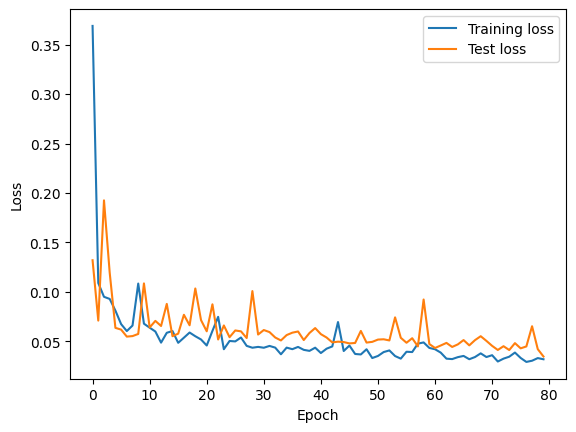

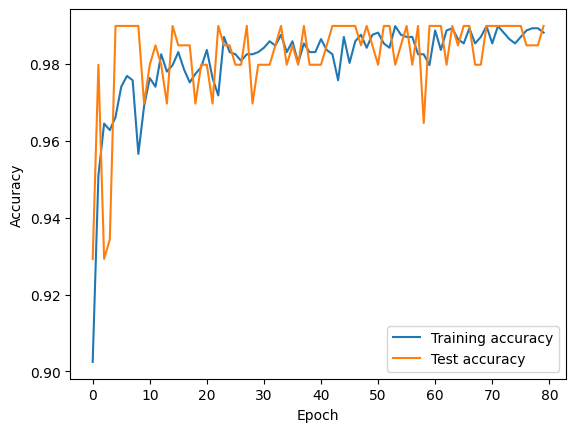

Fold 2, Epoch 1: Train Loss = 0.4363, Test Loss = 0.1768, Test Accuracy = 0.8838
Fold 2, Epoch 2: Train Loss = 0.1063, Test Loss = 0.1570, Test Accuracy = 0.9192
Fold 2, Epoch 3: Train Loss = 0.1066, Test Loss = 0.1462, Test Accuracy = 0.9545
Fold 2, Epoch 4: Train Loss = 0.0797, Test Loss = 0.1063, Test Accuracy = 0.9697
Fold 2, Epoch 5: Train Loss = 0.0713, Test Loss = 0.1481, Test Accuracy = 0.8889
Fold 2, Epoch 6: Train Loss = 0.0763, Test Loss = 0.0958, Test Accuracy = 0.9697
Fold 2, Epoch 7: Train Loss = 0.0704, Test Loss = 0.0971, Test Accuracy = 0.9495
Fold 2, Epoch 8: Train Loss = 0.0909, Test Loss = 0.0905, Test Accuracy = 0.9747
Fold 2, Epoch 9: Train Loss = 0.1019, Test Loss = 0.1745, Test Accuracy = 0.9495
Fold 2, Epoch 10: Train Loss = 0.0721, Test Loss = 0.1622, Test Accuracy = 0.8939
Fold 2, Epoch 11: Train Loss = 0.0677, Test Loss = 0.1400, Test Accuracy = 0.9545
Fold 2, Epoch 12: Train Loss = 0.0743, Test Loss = 0.1180, Test Accuracy = 0.9646
Fold 2, Epoch 13: Train L

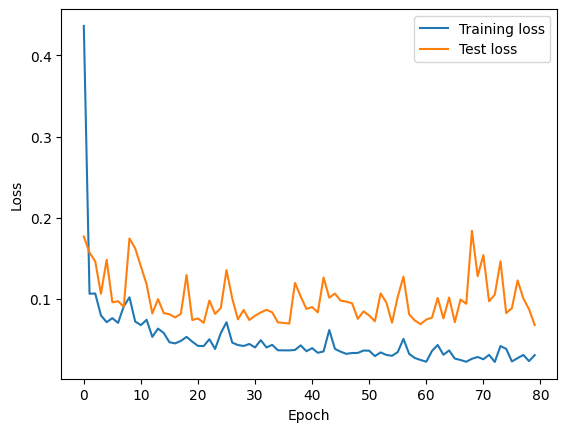

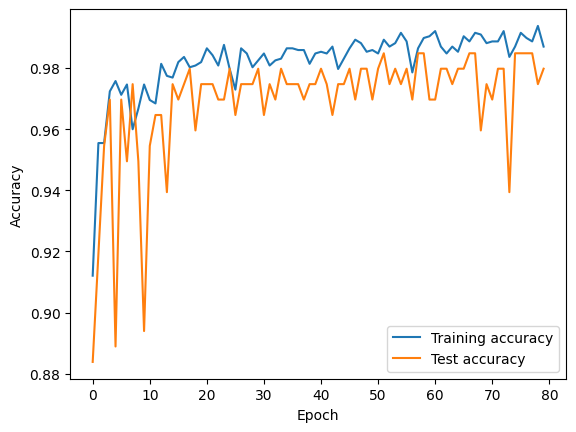

Fold 3, Epoch 1: Train Loss = 0.5456, Test Loss = 0.1274, Test Accuracy = 0.9492
Fold 3, Epoch 2: Train Loss = 0.1287, Test Loss = 0.1046, Test Accuracy = 0.9442
Fold 3, Epoch 3: Train Loss = 0.1045, Test Loss = 0.0605, Test Accuracy = 0.9594
Fold 3, Epoch 4: Train Loss = 0.0866, Test Loss = 0.0745, Test Accuracy = 0.9797
Fold 3, Epoch 5: Train Loss = 0.0904, Test Loss = 0.0672, Test Accuracy = 0.9645
Fold 3, Epoch 6: Train Loss = 0.0822, Test Loss = 0.0489, Test Accuracy = 0.9898
Fold 3, Epoch 7: Train Loss = 0.0768, Test Loss = 0.0772, Test Accuracy = 0.9594
Fold 3, Epoch 8: Train Loss = 0.0965, Test Loss = 0.0545, Test Accuracy = 0.9797
Fold 3, Epoch 9: Train Loss = 0.0932, Test Loss = 0.0349, Test Accuracy = 0.9898
Fold 3, Epoch 10: Train Loss = 0.0713, Test Loss = 0.0480, Test Accuracy = 0.9797
Fold 3, Epoch 11: Train Loss = 0.0809, Test Loss = 0.0401, Test Accuracy = 0.9848
Fold 3, Epoch 12: Train Loss = 0.0702, Test Loss = 0.0983, Test Accuracy = 0.9239
Fold 3, Epoch 13: Train L

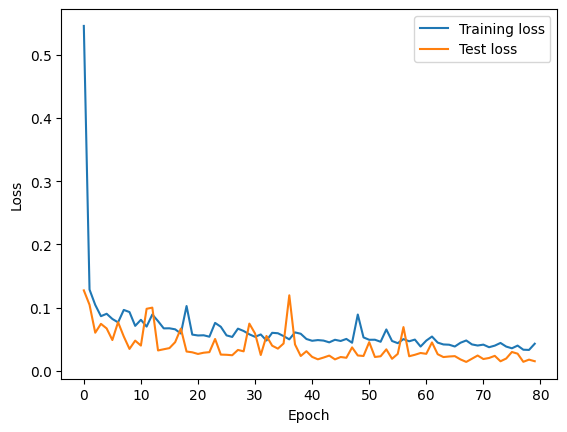

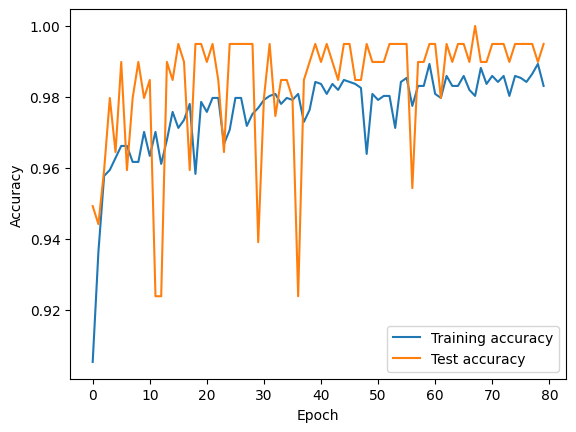

Fold 4, Epoch 1: Train Loss = 0.4753, Test Loss = 0.1069, Test Accuracy = 0.9492
Fold 4, Epoch 2: Train Loss = 0.1271, Test Loss = 0.0804, Test Accuracy = 0.9898
Fold 4, Epoch 3: Train Loss = 0.0994, Test Loss = 0.0629, Test Accuracy = 0.9543
Fold 4, Epoch 4: Train Loss = 0.1000, Test Loss = 0.0475, Test Accuracy = 0.9898
Fold 4, Epoch 5: Train Loss = 0.0945, Test Loss = 0.0464, Test Accuracy = 0.9898
Fold 4, Epoch 6: Train Loss = 0.0851, Test Loss = 0.0475, Test Accuracy = 0.9746
Fold 4, Epoch 7: Train Loss = 0.1153, Test Loss = 0.0822, Test Accuracy = 0.9442
Fold 4, Epoch 8: Train Loss = 0.0765, Test Loss = 0.0491, Test Accuracy = 0.9898
Fold 4, Epoch 9: Train Loss = 0.0678, Test Loss = 0.0370, Test Accuracy = 0.9949
Fold 4, Epoch 10: Train Loss = 0.0739, Test Loss = 0.1043, Test Accuracy = 0.9442
Fold 4, Epoch 11: Train Loss = 0.0809, Test Loss = 0.0435, Test Accuracy = 0.9848
Fold 4, Epoch 12: Train Loss = 0.0666, Test Loss = 0.0439, Test Accuracy = 0.9848
Fold 4, Epoch 13: Train L

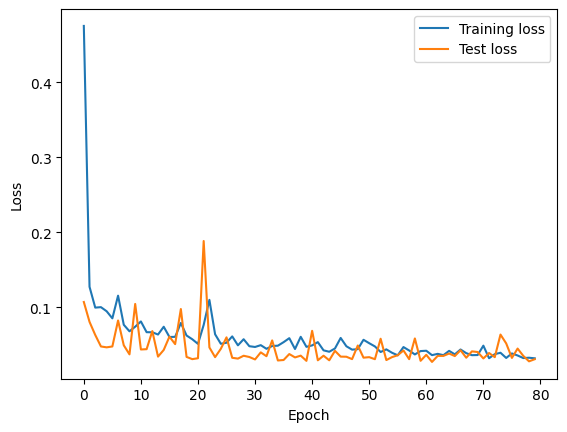

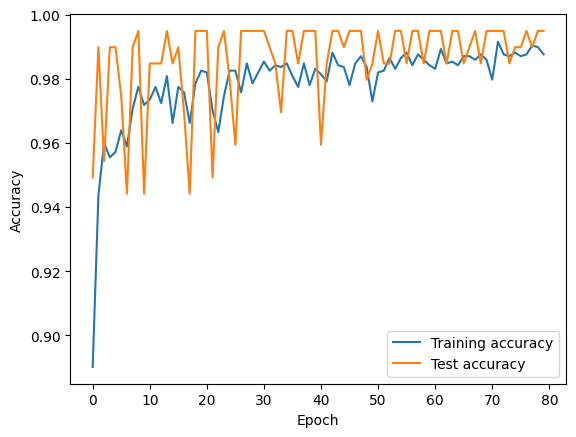

Fold 5, Epoch 1: Train Loss = 0.4252, Test Loss = 0.1444, Test Accuracy = 0.9289
Fold 5, Epoch 2: Train Loss = 0.1224, Test Loss = 0.1326, Test Accuracy = 0.9289
Fold 5, Epoch 3: Train Loss = 0.1041, Test Loss = 0.1072, Test Accuracy = 0.9442
Fold 5, Epoch 4: Train Loss = 0.0888, Test Loss = 0.1829, Test Accuracy = 0.9340
Fold 5, Epoch 5: Train Loss = 0.0799, Test Loss = 0.0866, Test Accuracy = 0.9645
Fold 5, Epoch 6: Train Loss = 0.0764, Test Loss = 0.0917, Test Accuracy = 0.9492
Fold 5, Epoch 7: Train Loss = 0.0685, Test Loss = 0.1010, Test Accuracy = 0.9492
Fold 5, Epoch 8: Train Loss = 0.0798, Test Loss = 0.0852, Test Accuracy = 0.9543
Fold 5, Epoch 9: Train Loss = 0.0555, Test Loss = 0.1282, Test Accuracy = 0.9391
Fold 5, Epoch 10: Train Loss = 0.0576, Test Loss = 0.0941, Test Accuracy = 0.9543
Fold 5, Epoch 11: Train Loss = 0.0734, Test Loss = 0.1308, Test Accuracy = 0.9492
Fold 5, Epoch 12: Train Loss = 0.0657, Test Loss = 0.0692, Test Accuracy = 0.9695
Fold 5, Epoch 13: Train L

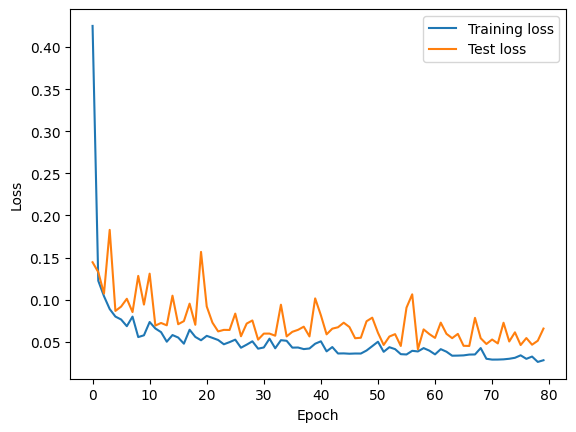

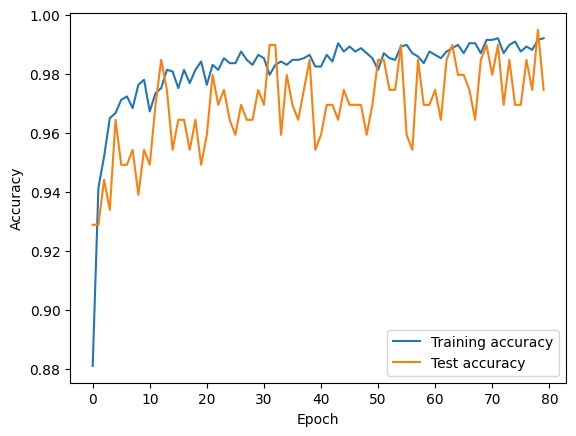

Fold 6, Epoch 1: Train Loss = 0.5975, Test Loss = 0.1553, Test Accuracy = 0.9036
Fold 6, Epoch 2: Train Loss = 0.1309, Test Loss = 0.1552, Test Accuracy = 0.9137
Fold 6, Epoch 3: Train Loss = 0.1270, Test Loss = 0.0662, Test Accuracy = 0.9848
Fold 6, Epoch 4: Train Loss = 0.1058, Test Loss = 0.0655, Test Accuracy = 0.9848
Fold 6, Epoch 5: Train Loss = 0.0912, Test Loss = 0.0643, Test Accuracy = 0.9797
Fold 6, Epoch 6: Train Loss = 0.0915, Test Loss = 0.0625, Test Accuracy = 0.9949
Fold 6, Epoch 7: Train Loss = 0.0630, Test Loss = 0.1363, Test Accuracy = 0.9239
Fold 6, Epoch 8: Train Loss = 0.0672, Test Loss = 0.0622, Test Accuracy = 0.9949
Fold 6, Epoch 9: Train Loss = 0.0698, Test Loss = 0.0637, Test Accuracy = 0.9949
Fold 6, Epoch 10: Train Loss = 0.0678, Test Loss = 0.0945, Test Accuracy = 0.9797
Fold 6, Epoch 11: Train Loss = 0.0786, Test Loss = 0.1132, Test Accuracy = 0.9492
Fold 6, Epoch 12: Train Loss = 0.0534, Test Loss = 0.0684, Test Accuracy = 0.9898
Fold 6, Epoch 13: Train L

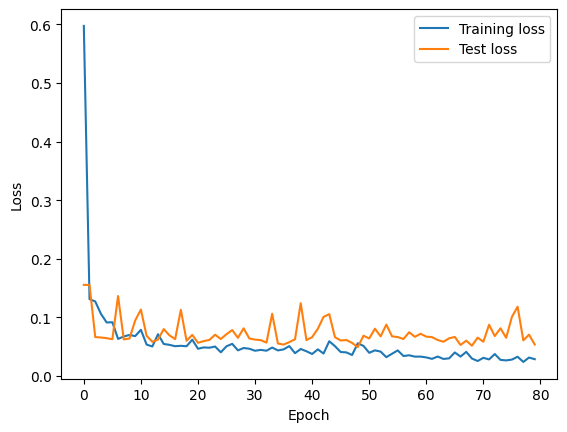

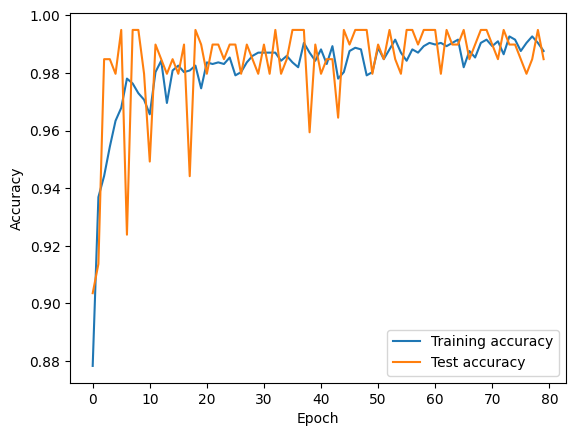

Fold 7, Epoch 1: Train Loss = 0.4761, Test Loss = 0.1318, Test Accuracy = 0.9239
Fold 7, Epoch 2: Train Loss = 0.1057, Test Loss = 0.1062, Test Accuracy = 0.9442
Fold 7, Epoch 3: Train Loss = 0.0839, Test Loss = 0.0873, Test Accuracy = 0.9391
Fold 7, Epoch 4: Train Loss = 0.0714, Test Loss = 0.0787, Test Accuracy = 0.9594
Fold 7, Epoch 5: Train Loss = 0.0751, Test Loss = 0.1194, Test Accuracy = 0.9492
Fold 7, Epoch 6: Train Loss = 0.0707, Test Loss = 0.0749, Test Accuracy = 0.9594
Fold 7, Epoch 7: Train Loss = 0.0635, Test Loss = 0.1151, Test Accuracy = 0.9492
Fold 7, Epoch 8: Train Loss = 0.1201, Test Loss = 0.1197, Test Accuracy = 0.9492
Fold 7, Epoch 9: Train Loss = 0.0750, Test Loss = 0.0697, Test Accuracy = 0.9492
Fold 7, Epoch 10: Train Loss = 0.0607, Test Loss = 0.0652, Test Accuracy = 0.9645
Fold 7, Epoch 11: Train Loss = 0.0643, Test Loss = 0.0630, Test Accuracy = 0.9645
Fold 7, Epoch 12: Train Loss = 0.0562, Test Loss = 0.0509, Test Accuracy = 0.9848
Fold 7, Epoch 13: Train L

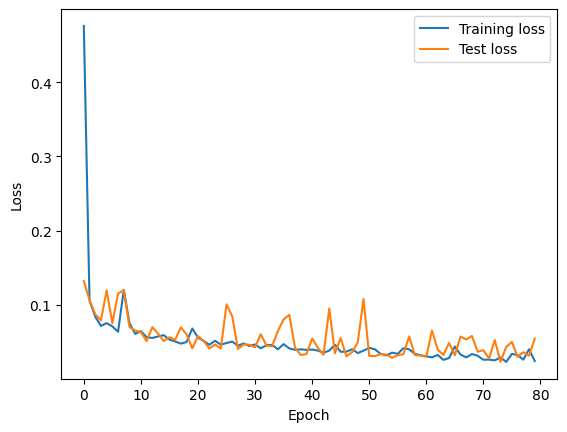

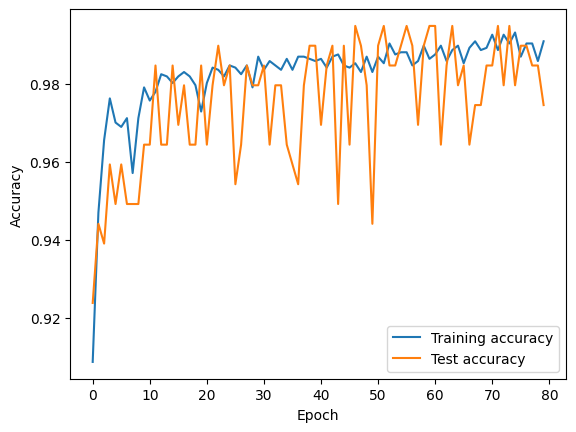

Fold 8, Epoch 1: Train Loss = 0.2904, Test Loss = 0.1258, Test Accuracy = 0.9746
Fold 8, Epoch 2: Train Loss = 0.1432, Test Loss = 0.0910, Test Accuracy = 0.9746
Fold 8, Epoch 3: Train Loss = 0.1026, Test Loss = 0.0667, Test Accuracy = 0.9645
Fold 8, Epoch 4: Train Loss = 0.0877, Test Loss = 0.0820, Test Accuracy = 0.9543
Fold 8, Epoch 5: Train Loss = 0.0958, Test Loss = 0.0670, Test Accuracy = 0.9645
Fold 8, Epoch 6: Train Loss = 0.0842, Test Loss = 0.0519, Test Accuracy = 0.9797
Fold 8, Epoch 7: Train Loss = 0.0757, Test Loss = 0.0555, Test Accuracy = 0.9594
Fold 8, Epoch 8: Train Loss = 0.0723, Test Loss = 0.0431, Test Accuracy = 0.9797
Fold 8, Epoch 9: Train Loss = 0.0702, Test Loss = 0.0592, Test Accuracy = 0.9797
Fold 8, Epoch 10: Train Loss = 0.0704, Test Loss = 0.0439, Test Accuracy = 0.9797
Fold 8, Epoch 11: Train Loss = 0.0720, Test Loss = 0.1250, Test Accuracy = 0.9746
Fold 8, Epoch 12: Train Loss = 0.0833, Test Loss = 0.0579, Test Accuracy = 0.9797
Fold 8, Epoch 13: Train L

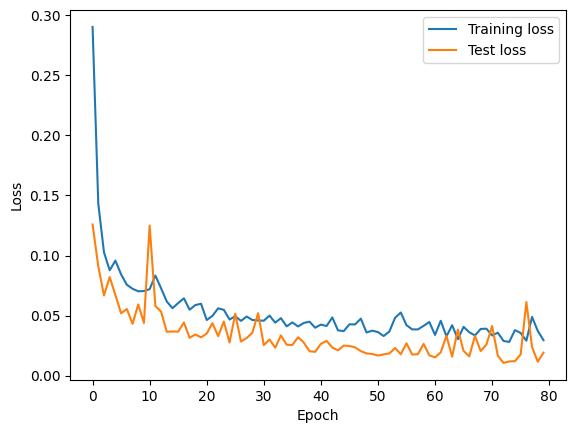

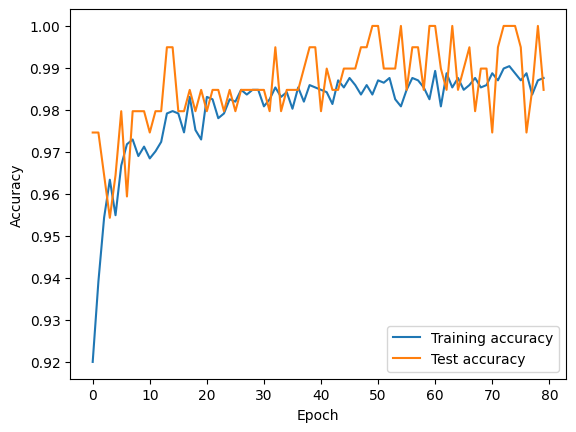

Fold 9, Epoch 1: Train Loss = 0.4200, Test Loss = 0.1471, Test Accuracy = 0.9340
Fold 9, Epoch 2: Train Loss = 0.1282, Test Loss = 0.1175, Test Accuracy = 0.9645
Fold 9, Epoch 3: Train Loss = 0.1209, Test Loss = 0.1356, Test Accuracy = 0.9645
Fold 9, Epoch 4: Train Loss = 0.0837, Test Loss = 0.1264, Test Accuracy = 0.9340
Fold 9, Epoch 5: Train Loss = 0.0798, Test Loss = 0.2517, Test Accuracy = 0.8528
Fold 9, Epoch 6: Train Loss = 0.0848, Test Loss = 0.0876, Test Accuracy = 0.9594
Fold 9, Epoch 7: Train Loss = 0.0763, Test Loss = 0.0882, Test Accuracy = 0.9695
Fold 9, Epoch 8: Train Loss = 0.0687, Test Loss = 0.1202, Test Accuracy = 0.9645
Fold 9, Epoch 9: Train Loss = 0.0840, Test Loss = 0.1463, Test Accuracy = 0.9340
Fold 9, Epoch 10: Train Loss = 0.0648, Test Loss = 0.0866, Test Accuracy = 0.9695
Fold 9, Epoch 11: Train Loss = 0.0605, Test Loss = 0.0839, Test Accuracy = 0.9645
Fold 9, Epoch 12: Train Loss = 0.0815, Test Loss = 0.0977, Test Accuracy = 0.9594
Fold 9, Epoch 13: Train L

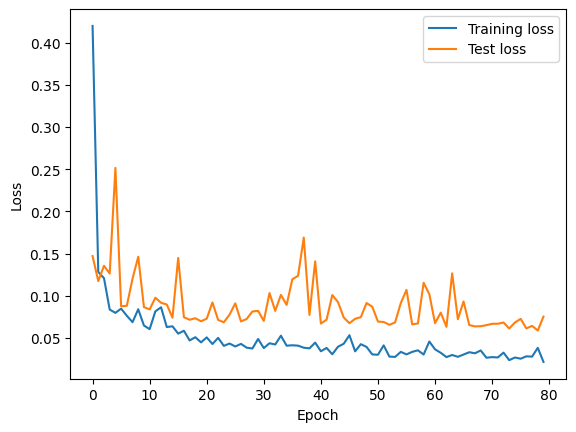

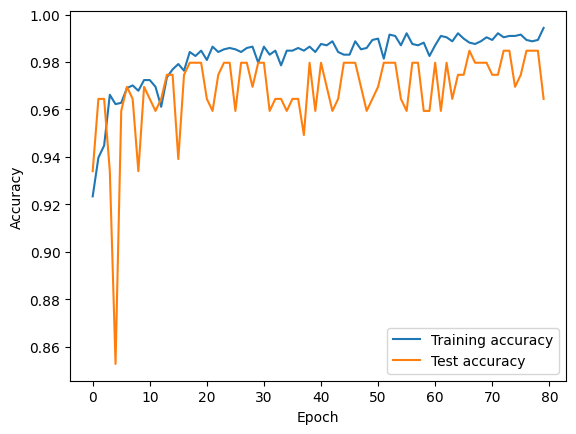

Fold 10, Epoch 1: Train Loss = 0.4910, Test Loss = 0.1783, Test Accuracy = 0.8883
Fold 10, Epoch 2: Train Loss = 0.1337, Test Loss = 0.0908, Test Accuracy = 0.9797
Fold 10, Epoch 3: Train Loss = 0.1135, Test Loss = 0.0894, Test Accuracy = 0.9797
Fold 10, Epoch 4: Train Loss = 0.0911, Test Loss = 0.0713, Test Accuracy = 0.9797
Fold 10, Epoch 5: Train Loss = 0.0854, Test Loss = 0.0549, Test Accuracy = 0.9797
Fold 10, Epoch 6: Train Loss = 0.0785, Test Loss = 0.0470, Test Accuracy = 0.9848
Fold 10, Epoch 7: Train Loss = 0.0918, Test Loss = 0.0401, Test Accuracy = 0.9898
Fold 10, Epoch 8: Train Loss = 0.0827, Test Loss = 0.0485, Test Accuracy = 0.9848
Fold 10, Epoch 9: Train Loss = 0.0799, Test Loss = 0.0769, Test Accuracy = 0.9695
Fold 10, Epoch 10: Train Loss = 0.0626, Test Loss = 0.0394, Test Accuracy = 0.9848
Fold 10, Epoch 11: Train Loss = 0.0869, Test Loss = 0.0363, Test Accuracy = 0.9898
Fold 10, Epoch 12: Train Loss = 0.0598, Test Loss = 0.0334, Test Accuracy = 0.9949
Fold 10, Epoc

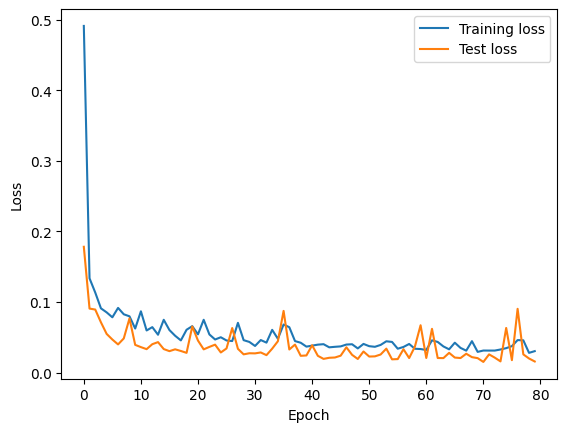

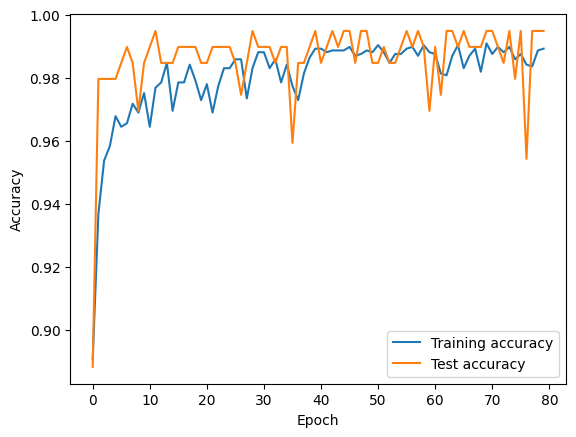

In [13]:
# --------------------------------------- 划分训练集和测试集---------------------------------------------
# 将输入数据 x 和对应的标签 y 封装为一个 TensorDataset 对象
dataset = TensorDataset(X_data, y_data)

# --------------------------------------- 交叉验证---------------------------------------------
kfold = KFold(n_splits=10, shuffle=True)

# 循环折叠
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 定义模型和训练器
    model = ParallelConvModel()  # 实例化模型
    criterion = nn.BCELoss()   # 二分类交叉熵损失函数
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

    model.to(device) # 将模型移动到GPU上

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    # 训练模型
    for epoch in range(80):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        test_loss, test_acc = test(model, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Fold {fold + 1}, Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

    plot_loss(train_losses, test_losses)
    plot_accuracy(train_accs, test_accs)

In [14]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')

Accuracy: 99.49%
F1 score: 96.00%
Recall: 100.00%
Precision: 97.96%


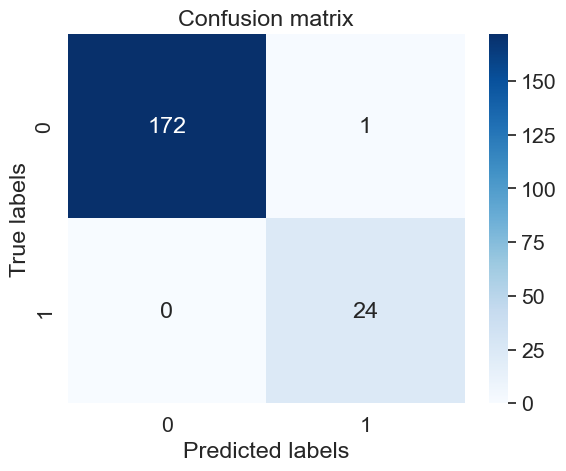

In [15]:
# 加载保存的模型参数
checkpoint = torch.load('model.pth') 
new_model=ParallelConvModel() #实例化模型
new_model.load_state_dict(checkpoint) 

### ------------------------------测试模型-------------------------------------
accuracy, f1, recall, precision,cm = YXJ.calculate_metrics(model, test_loader)
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1 score: {:.2f}%'.format(f1*100)) 
print('Recall: {:.2f}%'.format(recall*100))
print('Precision: {:.2f}%'.format(precision*100))

# 混淆矩阵
YXJ.plot_cm(cm)

In [16]:
### ------------------------------推理/预测-------------------------------------
model_path = 'model.pth'
data=torch.rand((1,6, 100)) # 生成随机数据
new_model=ParallelConvModel() #实例化模型
predict=YXJ.predict(new_model,model_path, data) # 调用预测函数
print(f"{predict.item():.4f}")

0.0000
